__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_flat.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

24487


,title,adr,latitude,longitude,priceM,ts
4486,"2-к. квартира, 42,1 м², 4/5 эт.","Севастополь, улица Героев Севастополя, 46",44.60,33.50,6.20,2022-08-29 13:16:00
179,"2-к. квартира, 52 м², 2/2 эт.","Севастополь, Планерная улица , 16",44.58,33.44,4.40,2022-08-26 17:29:00
1853,"квартира-студия, 31,5 м², 3/9 эт.","Севастополь, улица Горпищенко, д. 139",44.64,33.54,4.85,2022-08-26 17:29:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24487 entries, 0 to 24486
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   avito_id       18465 non-null  float64       
 1   title          24487 non-null  object        
 2   price          24487 non-null  int64         
 3   adr            24487 non-null  object        
 4   description    24487 non-null  object        
 5   obj_name       24487 non-null  object        
 6   ts             24487 non-null  datetime64[ns]
 7   avito_page     18465 non-null  float64       
 8   place          24487 non-null  object        
 9   nrooms         24487 non-null  int64         
 10  floor          24487 non-null  int64         
 11  nfloors        24487 non-null  int64         
 12  area           24487 non-null  float64       
 13  is_studio      24487 non-null  bool          
 14  is_apartment   24487 non-null  bool          
 15  is_part        2448

In [7]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

24487
24487


### ограничиваем тип объекта 

In [8]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

24487
20197


In [9]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
10643,"1-к. квартира, 40 м², 2/10 эт.","Севастополь, Парковая улица , 14 к2",44.57,33.53,8.70
2648,"3-к. квартира, 60 м², 5/5 эт.","Севастополь, улица Бутакова, 4",44.61,33.52,10.00
4975,"1-к. квартира, 42 м², 6/9 эт.","Севастополь, Античный проспект , 20",44.59,33.44,7.60


In [10]:
del df

In [11]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика изменение цены

In [12]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   10%   25%   50%   75%   90%    max
nrooms dt                                                                     
1      2022-08-26 1203.00  6.26 1.91 1.59  4.07  5.00  6.00  7.30  8.50  18.50
       2022-08-29 1191.00  6.25 1.90 1.75  4.11  5.00  6.00  7.21  8.50  18.50
       2022-08-31 1180.00  6.34 1.92 1.30  4.20  5.09  6.00  7.43  8.76  18.50
       2022-09-01 1159.00  6.32 1.89 1.30  4.15  5.10  6.00  7.40  8.51  18.50
       2022-09-02  365.00  6.31 2.10 3.65  4.00  4.85  5.81  7.21  9.35  14.90
       2022-09-05  372.00  6.21 2.10 3.10  3.99  4.81  5.55  7.07  9.35  14.90
       2022-09-06  372.00  6.22 2.10 3.15  3.99  4.83  5.62  7.05  9.33  14.90
       2022-09-07  320.00  6.35 2.10 3.10  4.09  4.87  5.80  7.26  9.35  14.90
       2022-09-08 1031.00  5.92 2.35 1.40  3.50  4.25  5.42  7.10  9.00  18.50
       2022-09-12  906.00  5.89 2.35 1.40  3.49  4.40  5.42  7.00  8.70  18.50
       2022-09-13  910.00  5.96 2.41 1.40  3.40  4.30  5.50  7.20  9.12  18.50
       2022-09-15  916.00  5.91 2.30 1.40  3.49  4.45  5.50  7.00  8.86  18.50
2      2022-08-26  942.00  8.82 3.30 2.80  5.80  6.55  8.13 10.20 12.67  36.00
       2022-08-29  937.00  8.87 3.30 2.80  5.88  6.70  8.18 10.40 12.64  36.00
       2022-08-31  926.00  8.83 3.20 2.60  5.80  6.66  8.10 10.34 12.85  35.00
       2022-09-01  948.00  8.90 3.32 2.65  5.80  6.70  8.18 10.50 12.90  36.00
       2022-09-02  112.00  9.66 2.65 4.91  6.36  7.55  9.43 11.53 12.97  15.70
       2022-09-05  131.00  9.76 2.70 4.92  6.40  8.00  9.28 11.37 13.65  15.70
       2022-09-06  187.00  9.71 2.69 4.91  6.32  7.83  9.28 11.45 13.65  15.70
       2022-09-07  128.00  9.75 2.85 4.91  6.20  7.49  9.14 11.77 13.93  15.70
       2022-09-08  560.00  9.44 4.16 3.20  6.00  6.74  8.39 11.13 13.65  49.12
       2022-09-12  476.00  9.25 4.34 3.00  5.70  6.60  8.22 10.88 13.63  49.12
       2022-09-13  474.00  9.16 4.38 3.00  5.65  6.54  8.18 10.61 13.60  49.12
       2022-09-15  495.00  9.10 4.16 3.00  5.90  6.60  8.18 10.60 13.58  49.12
3      2022-08-26  646.00 11.61 6.14 3.50  7.40  8.30 10.25 13.24 16.80 100.00
       2022-08-29  635.00 11.66 6.17 3.85  7.40  8.43 10.33 13.28 16.68 100.00
       2022-08-31  640.00 11.64 6.12 3.85  7.40  8.44 10.30 13.03 17.03 100.00
       2022-09-01  634.00 11.57 6.13 3.85  7.40  8.30 10.21 13.00 16.90 100.00
       2022-09-02   61.00 11.17 1.74 7.73 10.21 10.33 10.35 11.53 13.90  16.64
       2022-09-05   67.00 11.22 1.85 7.73 10.21 10.33 10.35 12.03 14.18  16.64
       2022-09-06   65.00 11.22 1.87 7.73 10.21 10.33 10.34 11.53 14.27  16.64
       2022-09-07   58.00 11.26 1.81 9.20 10.21 10.33 10.35 11.35 14.13  16.64
       2022-09-08  298.00 11.98 5.67 5.00  7.64  9.15 10.35 13.50 17.36  56.52
       2022-09-12  273.00 11.99 6.02 5.00  7.60  9.00 10.33 13.50 17.40  56.52
       2022-09-13  292.00 12.06 5.88 5.00  7.60  9.00 10.35 13.50 17.00  56.52
       2022-09-15  287.00 11.76 5.85 4.70  7.50  9.00 10.34 12.80 16.66  56.52

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

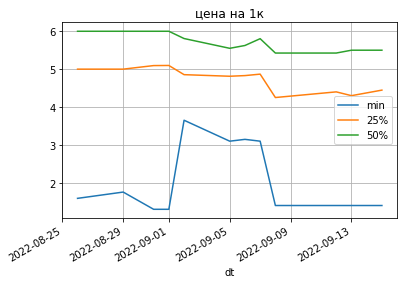

In [13]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

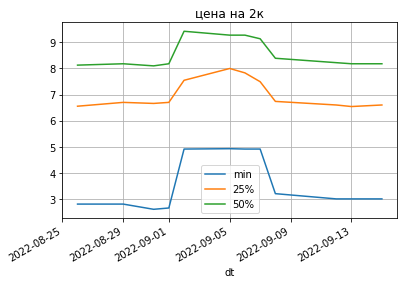

In [14]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

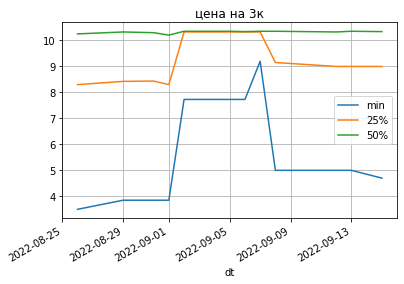

In [15]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

### район поиска

In [16]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [17]:
frame_all.explore()

### гексагональная сетка

In [18]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [19]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

25


,hex_id,geometry
23,862d2d59fffffff,"POLYGON ((33.48121 44.73827, 33.45978 44.70885, 33.48675 44.68010, 33.53515 44.68076, 33.55659 44.71016, 33.52964 44.73892, 33.48121 44.73827))"
24,862d28957ffffff,"POLYGON ((33.49782 44.56366, 33.47643 44.53419, 33.50334 44.50539, 33.55163 44.50606, 33.57303 44.53552, 33.54614 44.56432, 33.49782 44.56366))"


In [20]:
grid.explore()

### медиана актуальной цены

In [21]:
ts = '2022-08-01' # ограничиваем дату

# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [22]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"


In [23]:
frames.explore('area_name', legend=True)

In [24]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

20197
2632


In [25]:
# новые (актуальные) предложения
gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)

### изменение цены

In [26]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%   75%   90%   max
nrooms dt                                                                
1      2022-08-26 207.00  5.86 2.35 1.65 3.72 4.12 5.40  7.00  8.52 18.50
       2022-08-29 215.00  6.03 2.39 1.75 3.72 4.16 5.50  7.05  8.87 18.50
       2022-08-31 209.00  6.02 2.36 1.30 3.71 4.25 5.50  7.00  8.72 18.50
       2022-09-01 209.00  5.91 2.33 1.30 3.72 4.11 5.50  7.00  8.72 18.50
       2022-09-02  72.00  5.33 2.92 3.65 3.67 3.88 4.02  5.05  8.95 14.90
       2022-09-05  75.00  5.16 2.94 3.10 3.65 3.91 3.99  4.24  8.91 14.90
       2022-09-06  79.00  5.29 2.91 3.15 3.67 3.90 4.02  5.01  8.92 14.90
       2022-09-07  55.00  5.55 3.19 3.10 3.65 3.88 3.98  5.41  9.53 14.90
       2022-09-08 134.00  5.22 2.51 1.85 3.67 3.91 4.22  5.50  7.99 14.90
       2022-09-12  82.00  5.61 2.71 1.85 3.60 4.10 4.90  5.97  8.91 14.90
       2022-09-13  72.00  5.56 2.75 1.85 3.24 3.96 4.55  5.99  8.91 14.90
       2022-09-15  80.00  5.38 2.26 1.85 3.57 4.19 4.75  5.99  8.72 14.90
2      2022-08-26 131.00  8.62 2.99 4.30 5.90 6.50 8.00  9.50 12.60 24.70
       2022-08-29 136.00  8.45 2.91 4.30 5.88 6.50 7.85  9.30 12.55 24.70
       2022-08-31 124.00  8.40 2.86 4.30 5.86 6.50 7.95  9.00 12.35 24.70
       2022-09-01 131.00  8.47 2.95 4.30 5.80 6.50 7.90  9.25 12.60 24.70
       2022-09-02   4.00  6.73 0.54 6.34 6.35 6.36 6.53  6.90  7.26  7.50
       2022-09-05   4.00  6.73 0.54 6.34 6.35 6.36 6.53  6.90  7.26  7.50
       2022-09-06   6.00  6.62 0.46 6.24 6.29 6.35 6.46  6.67  7.10  7.50
       2022-09-07   2.00  6.52 0.25 6.34 6.38 6.43 6.52  6.61  6.66  6.70
       2022-09-08  52.00  7.83 2.29 4.90 6.21 6.39 6.90  8.55 10.95 17.00
       2022-09-12  50.00  7.70 2.35 4.90 5.84 6.30 6.85  8.50 11.04 17.00
       2022-09-13  49.00  7.78 2.34 5.15 5.97 6.30 6.90  8.50 11.08 17.00
       2022-09-15  52.00  7.68 2.31 4.90 5.82 6.30 6.90  8.27 10.95 17.00
3      2022-08-26  73.00 10.69 3.86 6.35 7.52 8.00 9.80 11.99 14.64 32.00
       2022-08-29  69.00 10.78 4.29 6.35 7.50 8.20 9.35 11.99 14.16 32.00
       2022-08-31  66.00 10.93 4.35 6.95 7.55 8.22 9.50 11.82 14.90 32.00
       2022-09-01  68.00 10.86 4.37 6.95 7.50 8.00 9.43 11.99 15.27 32.00
       2022-09-02   1.00  9.50  NaN 9.50 9.50 9.50 9.50  9.50  9.50  9.50
       2022-09-05   1.00  9.50  NaN 9.50 9.50 9.50 9.50  9.50  9.50  9.50
       2022-09-06   1.00  9.50  NaN 9.50 9.50 9.50 9.50  9.50  9.50  9.50
       2022-09-08  26.00  9.88 1.92 7.30 8.05 8.62 9.38 10.50 11.75 15.30
       2022-09-12  32.00  9.37 2.01 6.90 7.30 7.94 9.05 10.27 11.43 15.30
       2022-09-13  34.00  9.73 2.28 6.90 7.36 8.33 9.32 10.50 11.85 16.70
       2022-09-15  31.00  9.86 2.35 6.90 7.30 8.35 9.50 10.50 12.00 16.70

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

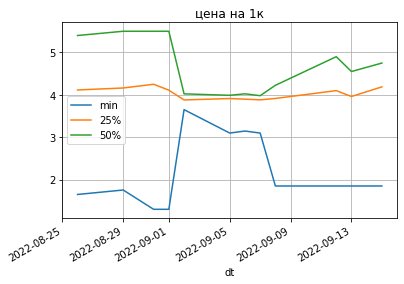

In [27]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

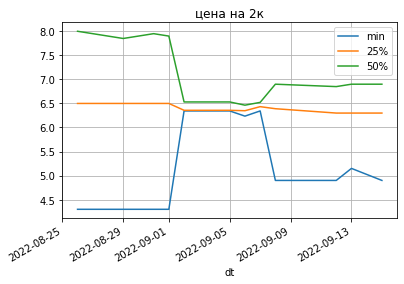

In [28]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

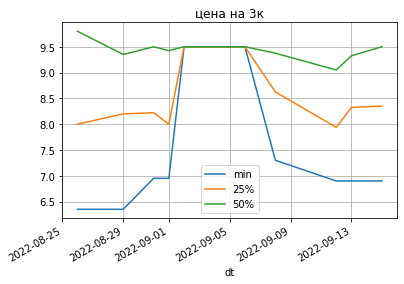

In [29]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

### гексагональная сетка

In [30]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
46,892d289519bffff,"POLYGON ((33.52831 44.55456, 33.52798 44.55277, 33.53007 44.55161, 33.53247 44.55223, 33.53280 44.55402, 33.53071 44.55519, 33.52831 44.55456))"
1,892d2895193ffff,"POLYGON ((33.52655 44.55751, 33.52622 44.55572, 33.52831 44.55456, 33.53071 44.55519, 33.53104 44.55698, 33.52895 44.55814, 33.52655 44.55751))"


### медиана актуальной цены

In [31]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)